# Obligatorio de Análisis Predictivo de Series Temporales
## Conteo Vehícular y aproximación Poisson

**Estudiantes:**

Felipe Bastarrica  (187231)

Emiliano Espíndola (......)

## Descripción

Se pretende ajustar un modelo Poisson de media dependiente del tiempo para la cantidad de autos que transitan por una calle a lo largo de un día, obteniendo una distribución de probabilidad que nos permite simular estos eventos.

Se trabaja con datos reales obtenidos por la Intendencia de Montevideo, a través del Centro de Gestión de Movilidad,  mediante sus contadores de autos ubicados en diferentes puntos de la ciudad. Estos datos vienen en intervalos acumulados de a 5 minutos y son captados por separado por cada carril que corre en un mismo sentido.

Los datos relevados haciendo uso de estos dispositivos, son de dominio público y la Intendencia los disponibiliza a travéz del sistio [catálogo de datos](https://catalogodatos.gub.uy/dataset/intendencia-montevideo-conteo-de-vehiculos-del-centro-de-gestion-de-la-movilidad) que pertenece al estado.

Nos motivó el hecho de que el set de datos tenía muchas medidas con una frecuencia muy alta.

## Formato de los datos originales

Originalmente los datos se presentan por archivos que acumulan períodos grandes de tiempo (meses, semestres, etc), variando según el año de relevamiento. 

Cada uno de estos archivos posee, además del volumen de autos acumulados cada 5 minutos, el dato acumulado durante la última hora y otros parámetros que se muestran en la tabla:

| Dato  | Tipo    | Descripción |
|-------|---------|-------------|
| id_detector | Entero | Indica el *id* de la cámara que está monitoerando un determinado carril donde realiza el análisis de imagen para detectar la presencia de un vehículo |
| id_carril | Entero | Es el número del carril que se está monitoreando. Va de 1 en adelante, siendo 1 el carril de más a la izquierda |
| **fecha** | **AAAA-MM-DD** | **Fecha en que fue tomada la muestra** |
| **hora** | **hh:mm:ss** | **Hora en que fue tomada la muestra** |
| dsc_avenida | Texto | Nombre de la vía en la que se mide el tránsito |
| dsc_int_anterior | Texto | Nombre de la vía que forma el cruce desde donde vienen los vehículos |
| dsc_int_siguiente | Texto | Nombre de la vía que forma el cruce donde está el medidor, en general el mismo se encuentra un poco antes de esta vía. El sentido de circulación será desde el curce con dsc_int_anterior hacia el curce con dsc_int_siguiente. |
| latitud | Float | latitud de donde está el medidor |
| longitud | Float | longitud de donde está el medidor |
| **volumen** | **Enterno** | **Cantidad de vehículos detectados en el carril en los últimos 5 minutos** |
| volumen_hora | Enterno | Cantidad de vehículos detectados en el carril en la última hora |

## Pre procesamiento

Para el trabajo obligatorio se realizaron varias transformaciones previas sobre los datos:

- Se tomó en cuenta la zona de *Sarmiento y Av. José Requena y García* con dirección a la rambla. Por lo que se tuvo que filtrar los archivos de varios años, tomando solo los datos referidos a este punto.

- Se acumularon los datos a medidas cada 15 minutos, en vez de 5, ya que eran un volúmen de datos considerable que no aportaba al objetivo planteado.

- Se agregan los datos de los 3 carriles allí existentes, contando únicamente los autos que pasaron en total.

- Se tomó en cuenta la *fecha* y *hora* para lograr armar una serie de tiempo

- Se completaron los datos faltantes con la media de la serie con las que se contaba originalmente.

## Instalaciones y bibliotecas utilizadas

In [1]:
# Instalaciones
#install.packages("data.table")

In [2]:
#Bibliotecas
library(astsa)
library(forecast)
library(data.table) 

#Ajuste de tamaño de gráficas
options(repr.plot.width=15, repr.plot.height=8)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas




## Datos

In [145]:
# Ejemplo de los datos crudos descargados de la web
df_ejemplo <- read.csv("./dataframe_ejemplo.csv", )
head(df_ejemplo)

,id_detector,id_carril,fecha,hora,dsc_avenida,dsc_int_anterior,dsc_int_siguiente,latitud,longitud,volumen,volumen_hora
,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>
0,1,3,2017-01-01,00:00:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,0,0
1,1,3,2017-01-01,00:05:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,0,0
2,1,3,2017-01-01,00:10:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,6,72
3,1,3,2017-01-01,00:15:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,2,24
4,1,3,2017-01-01,00:20:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,3,36
5,1,3,2017-01-01,00:25:00,Sarmiento,Requena,Rambla,-34.91537,-56.16836,6,72


Se elige la avenida *Sarmiento* para esta tarea, donde el mismo cuenta con 3 detectores en total, cubriendo cada uno de sus carriles. Luego de un procesamiento, se llega a un dataframe con una columna de fechas **date** y otra con **volumen**. Este procesamiento se hace fuera de la Notebook con el script `main.py`, donde se saca la infomación de cada `csv`, en este caso, todo 2017.

In [146]:
# Datos crudos obtenidos cada 5 minutos de cada sensor de carril 
df_raw = read.csv("./2017_2018_raw.csv", sep =";")
head(df_raw) 
tail(df_raw)

,date,volumen
,<chr>,<int>
1,1/1/17 00:00,0
2,1/1/17 00:00,0
3,1/1/17 00:00,0
4,1/1/17 00:05,0
5,1/1/17 00:05,0
6,1/1/17 00:05,0


,date,volumen
,<chr>,<int>
307837,31/12/17 23:50,0
307838,31/12/17 23:50,3
307839,31/12/17 23:50,0
307840,31/12/17 23:55,0
307841,31/12/17 23:55,3
307842,31/12/17 23:55,0


### Definición de frecuencias

In [7]:
freq_5min = 365 * 24 * 60 / 5
freq_15min = 365 * 24 * 60 / 15
freq_sem_15min = 365 * 24 * 60 / ( 3 * 5 * (365 / 7) )

### Primer estudio de los datos

Se convierte a una serie de tiempo los datos cargados, sumarizándolos cada 15 minutos.

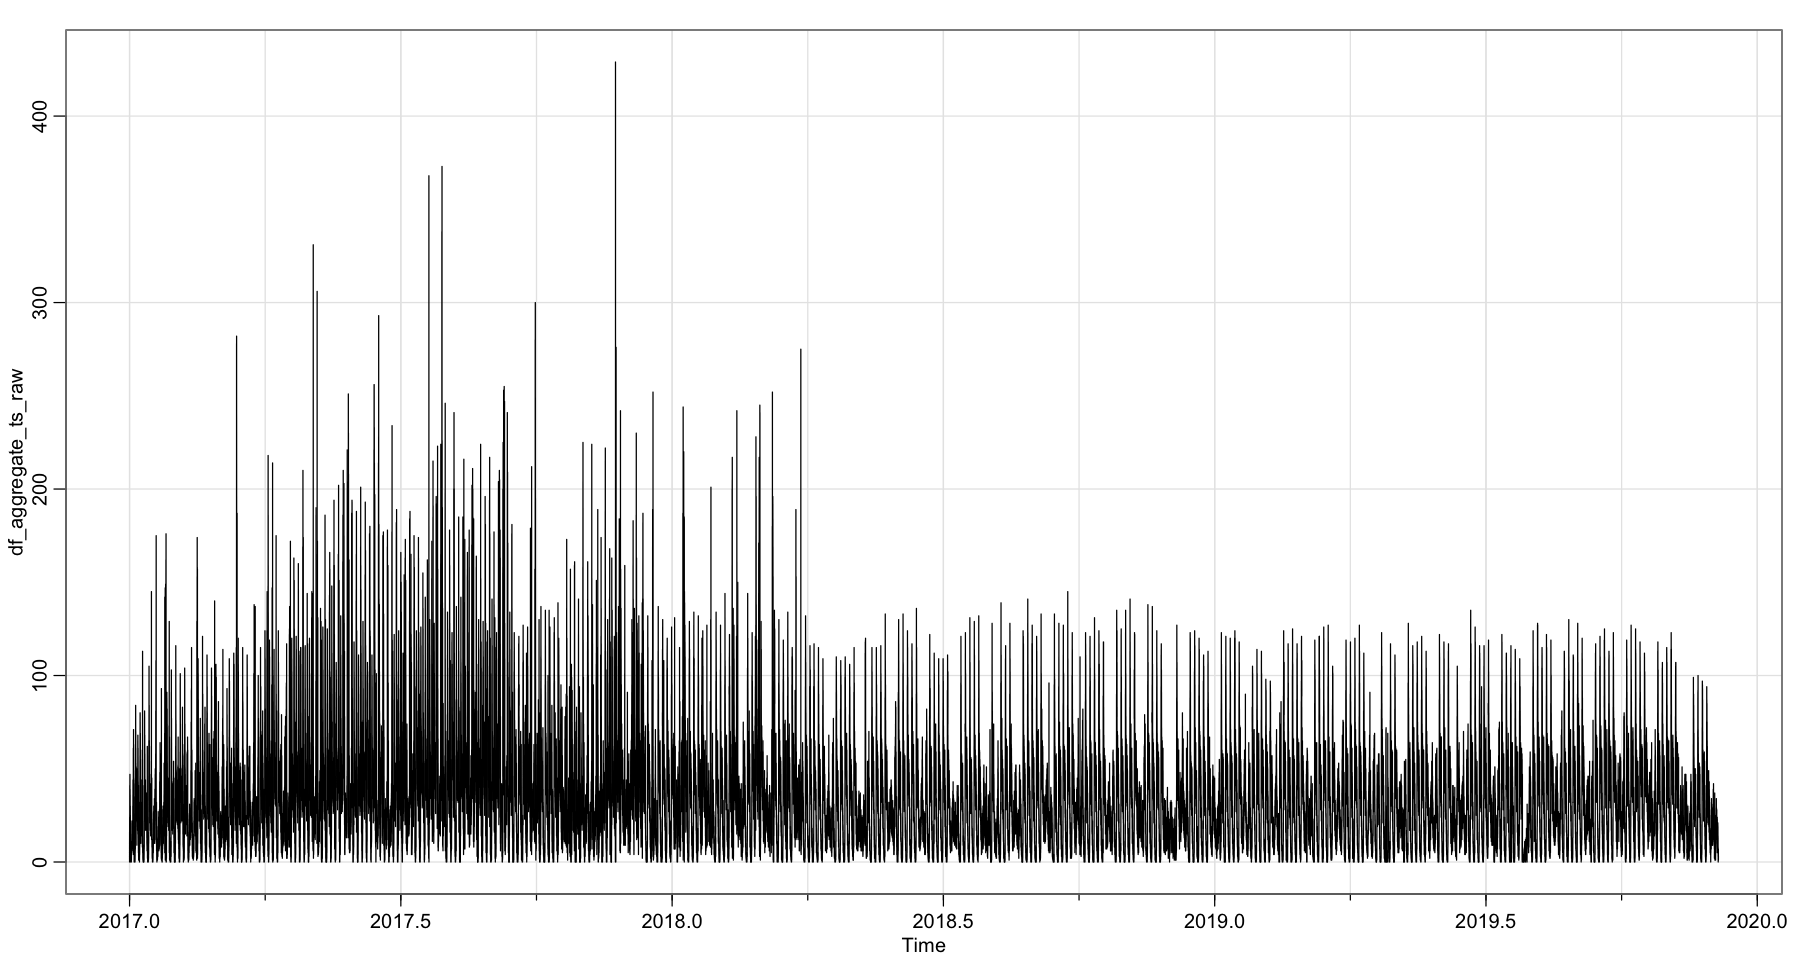

In [9]:
# Generar una serie de tiempo con datos cada 5 minutos
df_ts_raw = ts(df_raw$volumen, frequency=freq_5min, start=c(2017,1))

# Agregar la serie anterior cada 15 minutos (sumando los volúmenes)
df_aggregate_raw = aggregate(df_ts_raw, nfrequency = freq_15min, FUN = sum)
df_aggregate_ts_raw = ts(df_aggregate_raw, frequency = freq_15min, start=c(2017,1))

# Plot de la TS
tsplot(df_aggregate_ts_raw)

En esta serie se puede ver que no alcanza el 2018, porque faltan datos en varios momentos del año, para corregir esto, se generó una serie anual con la frecuencia deseada y se hico un *merge* con los datos originales.

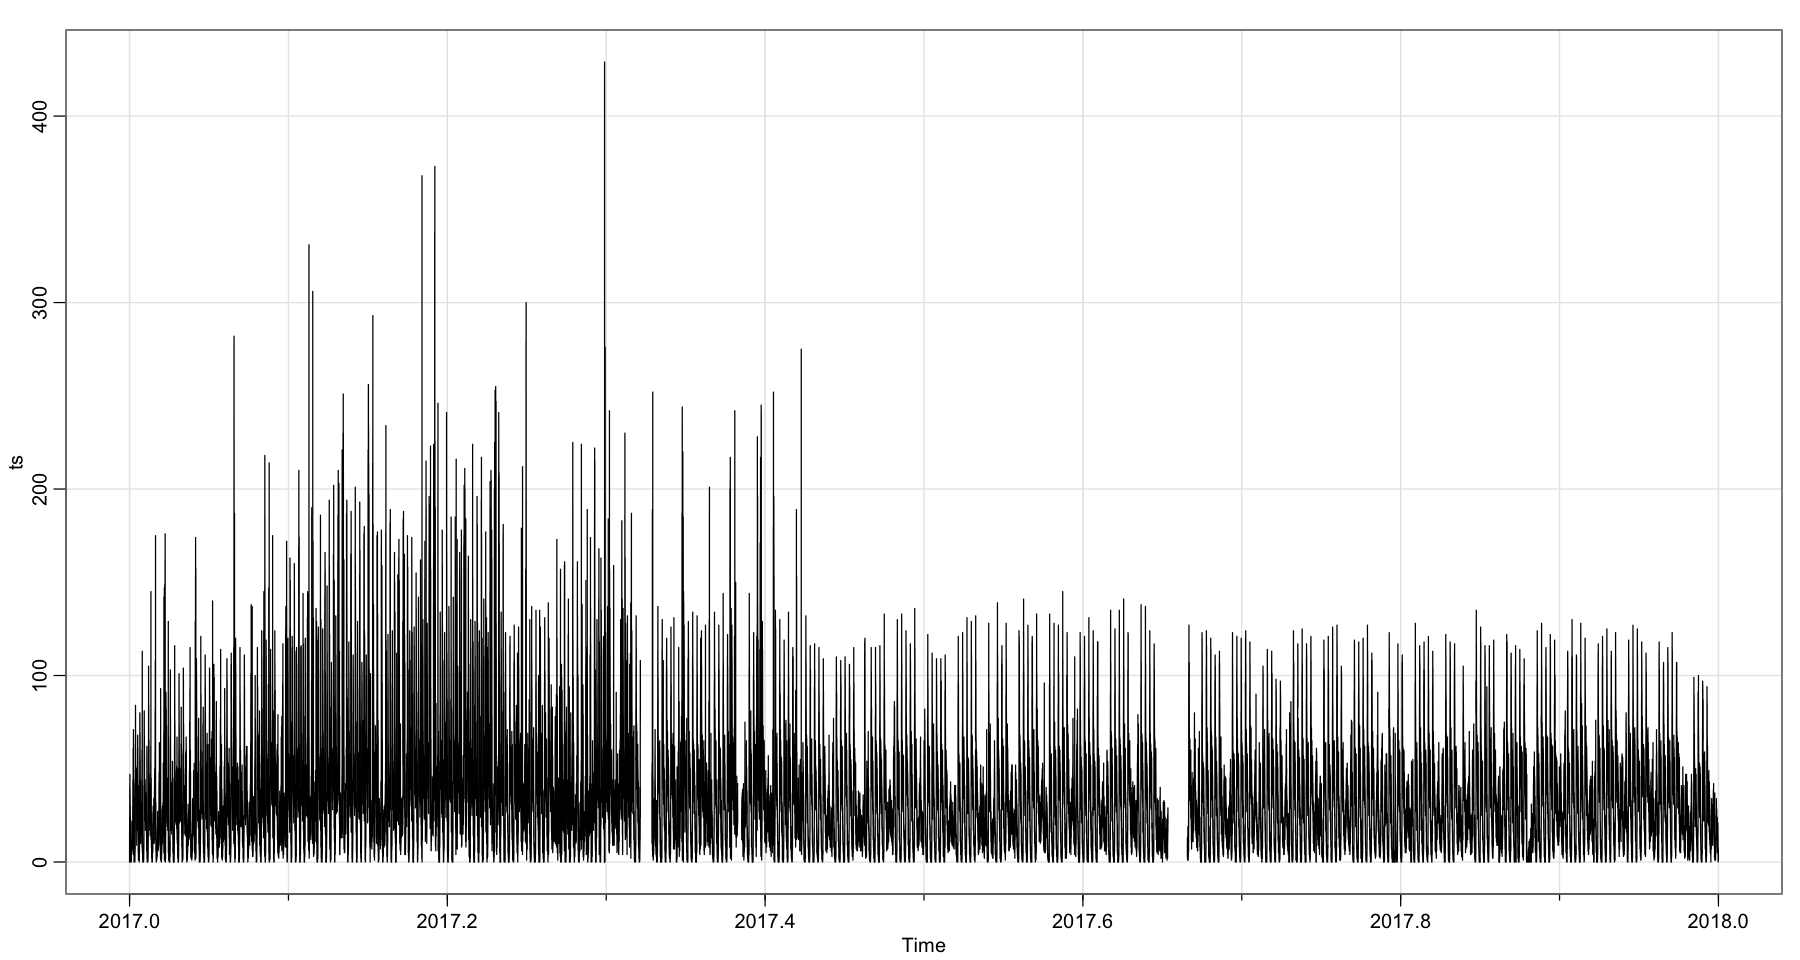

In [147]:
# Copia de dataframe original
originaldf <- df_raw

# Creación de nueva columna para new date
originaldf$minAsPOSIX <- as.POSIXct(originaldf$date, format="%d/%m/%y %H:%M",tz="GMT")

# Generación del vector para cada 5 minutos
ndays <- 365 # días a generar
minAsNumeric <-seq(0, 60 * 60 * 24 * ndays, by = 60 * 5) # de 0 a 365 días con un paso de 5 minutos

# Conversión de secuencia a posix (formato calendario)
minAsPOSIX <- as.POSIXct(minAsNumeric, origin = "2017-01-01", tz = "GMT")

# Columna con datos calendario para 1 año 
base_df = data.frame(minAsPOSIX)

# Merge de datos calendario completos con los datos de volumen original
df_merged <- merge(base_df, originaldf, all.x = TRUE, by="minAsPOSIX")

# Agregación de datos de volumen por los carriles (los que tengan misma fecha y hora los suma)
newdf = aggregate(df_merged$volumen, by = list(Date=df_merged$minAsPOSIX), FUN=sum)
colnames(newdf) <- c('date', 'volumen')

ts = ts(newdf$volumen, frequency=freq_5min, start=c(2017,1))
tsplot(ts)

#TODO: Agregar cada 15 min

Ahora se obtiene un nuevo dataframe donde en la primer columna están los datos ***date*** de fecha completos en todo el tiempo deseado sin huecos, con su correspondiente sumarización en la columna ***volumen***.

En caso de faltar datos, quedan `NA`, luego serán sustituidos por la media de la serie a trabajar.

Se analiza en períodos más cortos para visualizar la forma, reconocer mejor los días, las semanas y los fines de semana. 

**NOTA:** El 1/1/2017 fue domingo.

[1] "Media: 29.6276912885061"


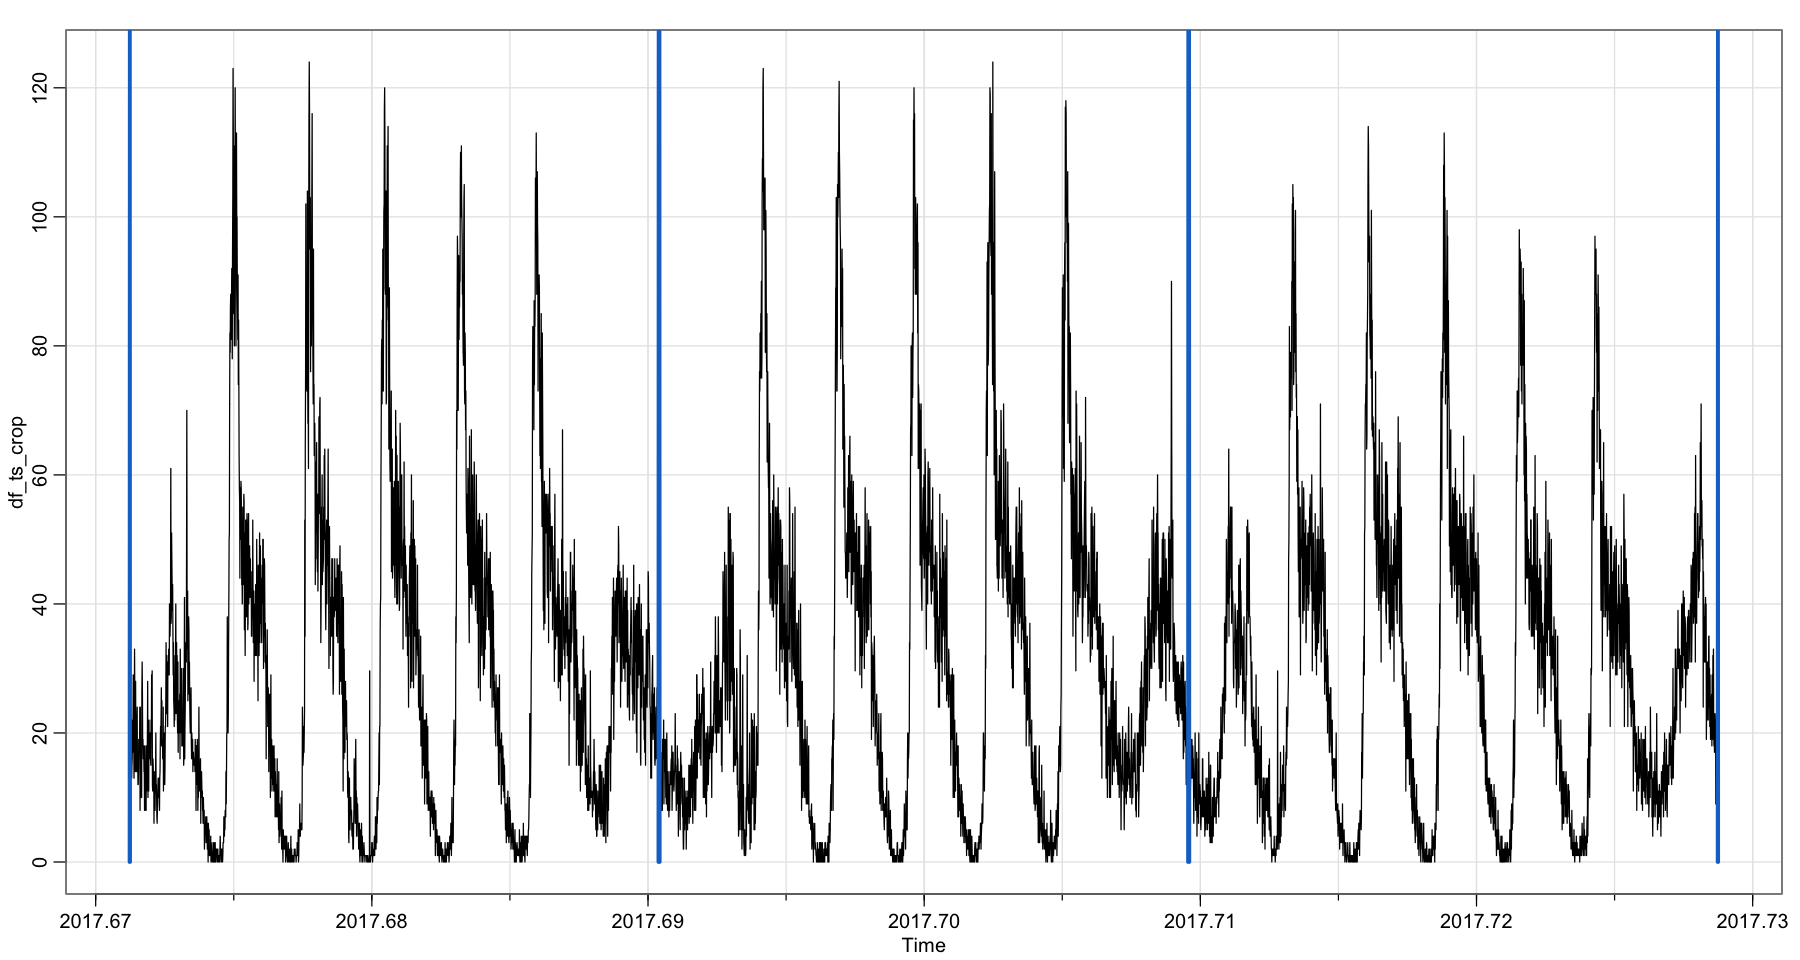

In [150]:
# Muestras por día (1 muestra cada 5 minutos x 2)
samples_per_day = (60 / 5) * 24
samples_per_week = samples_per_day * 7

# Días a tomar para análisis más pequeño
days_to_crop = 21
initial_week = 35

# Intervalo
ini = initial_week * samples_per_week
fin = ini + samples_per_day * days_to_crop
st = 2017 + ini/length(ts)

# Serie recortada
df_crop = ts[ini : fin]

# Promedio de serie cortada y sustituir
mean = mean(df_crop, na.rm=TRUE)
print(paste("Media:", mean))
df_crop[is.na(df_crop)] = mean
df_ts_crop = ts(df_crop, start = st, freq = freq_5min)

# Plot de la serie cortada
tsplot(df_ts_crop)

# Plot barras en las semanas
lp = 2
picos = rep(c( 0, rep(150, lp/2), 0 ,rep(NA, samples_per_week - lp - 4), 0 , rep(150, lp/2), 0 ), days_to_crop/7)
ts_picos = ts(picos, start = st, freq = freq_5min)
lines(ts_picos, lwd = 3, col = 4)

## Ajustes

### Serie a utilizar

Visto que la serie difiere mucho con las estaciones del año, se decide utilizar el último 30% de la serie (setiembre a diciembre aproximadamente).

[1] "Media: 30.2471385934919"


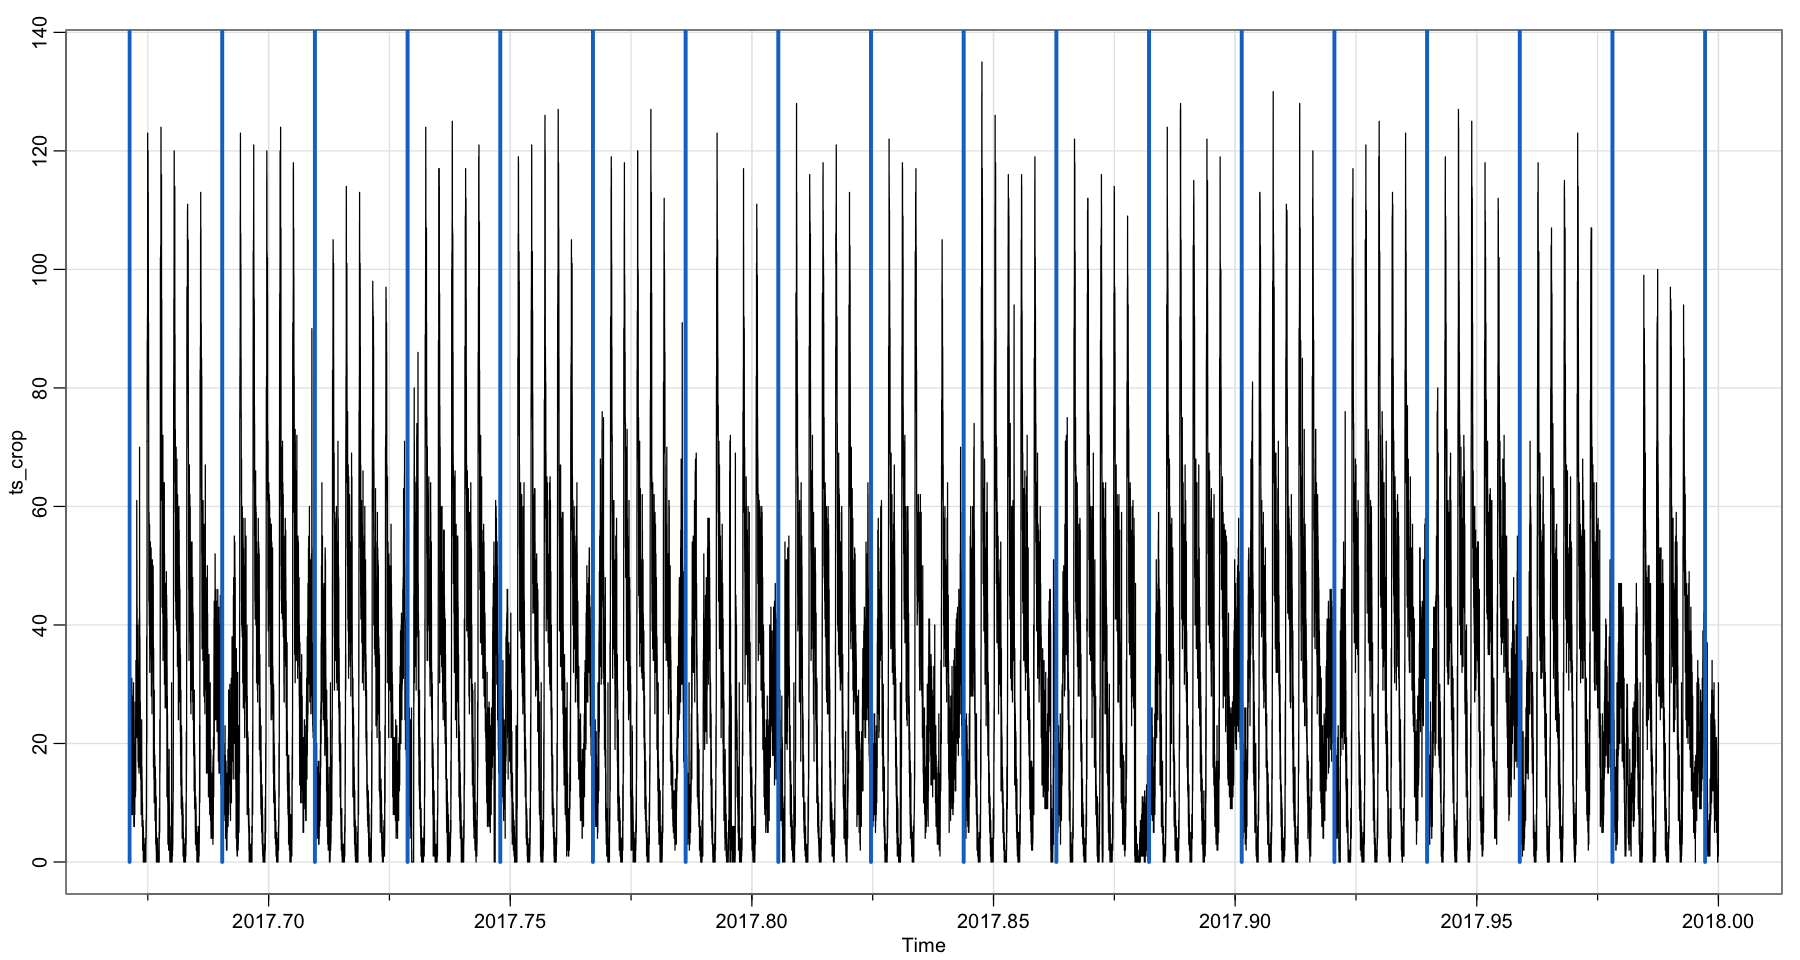

In [151]:
# Intervalo
ini = 35 * samples_per_week
fin = length(ts)
st = 2017 + ini/length(ts)

# Serie recortada
df_crop = ts[ini : fin]

# Media de serie cortada y sustituir los NAs
mean = mean(df_crop, na.rm=TRUE)
print(paste("Media:", mean))
df_crop[is.na(df_crop)] = mean
ts_crop = ts(df_crop, start = st, freq = freq_5min)

# Plot de la serie cortada
tsplot(ts_crop)

# Plot barras en las semanas
lp = 2
picos = rep(c( 0, rep(150, lp/2), 0 ,rep(NA, samples_per_week - lp - 4), 0 , rep(150, lp/2), 0 ), 52 - initial_week)
ts_picos = ts(picos, start = st, freq = freq_5min)
lines(ts_picos, lwd = 3, col = 4)

Se superponen las series semanalmente para ver su comportamiento.

In [161]:
ggseasonplot(ts_crop)

ERROR: [1m[33mError[39m in `check_breaks_labels()`:[22m
[1m[22m[33m![39m `breaks` and `labels` must have the same length


### Ajuste ARIMA

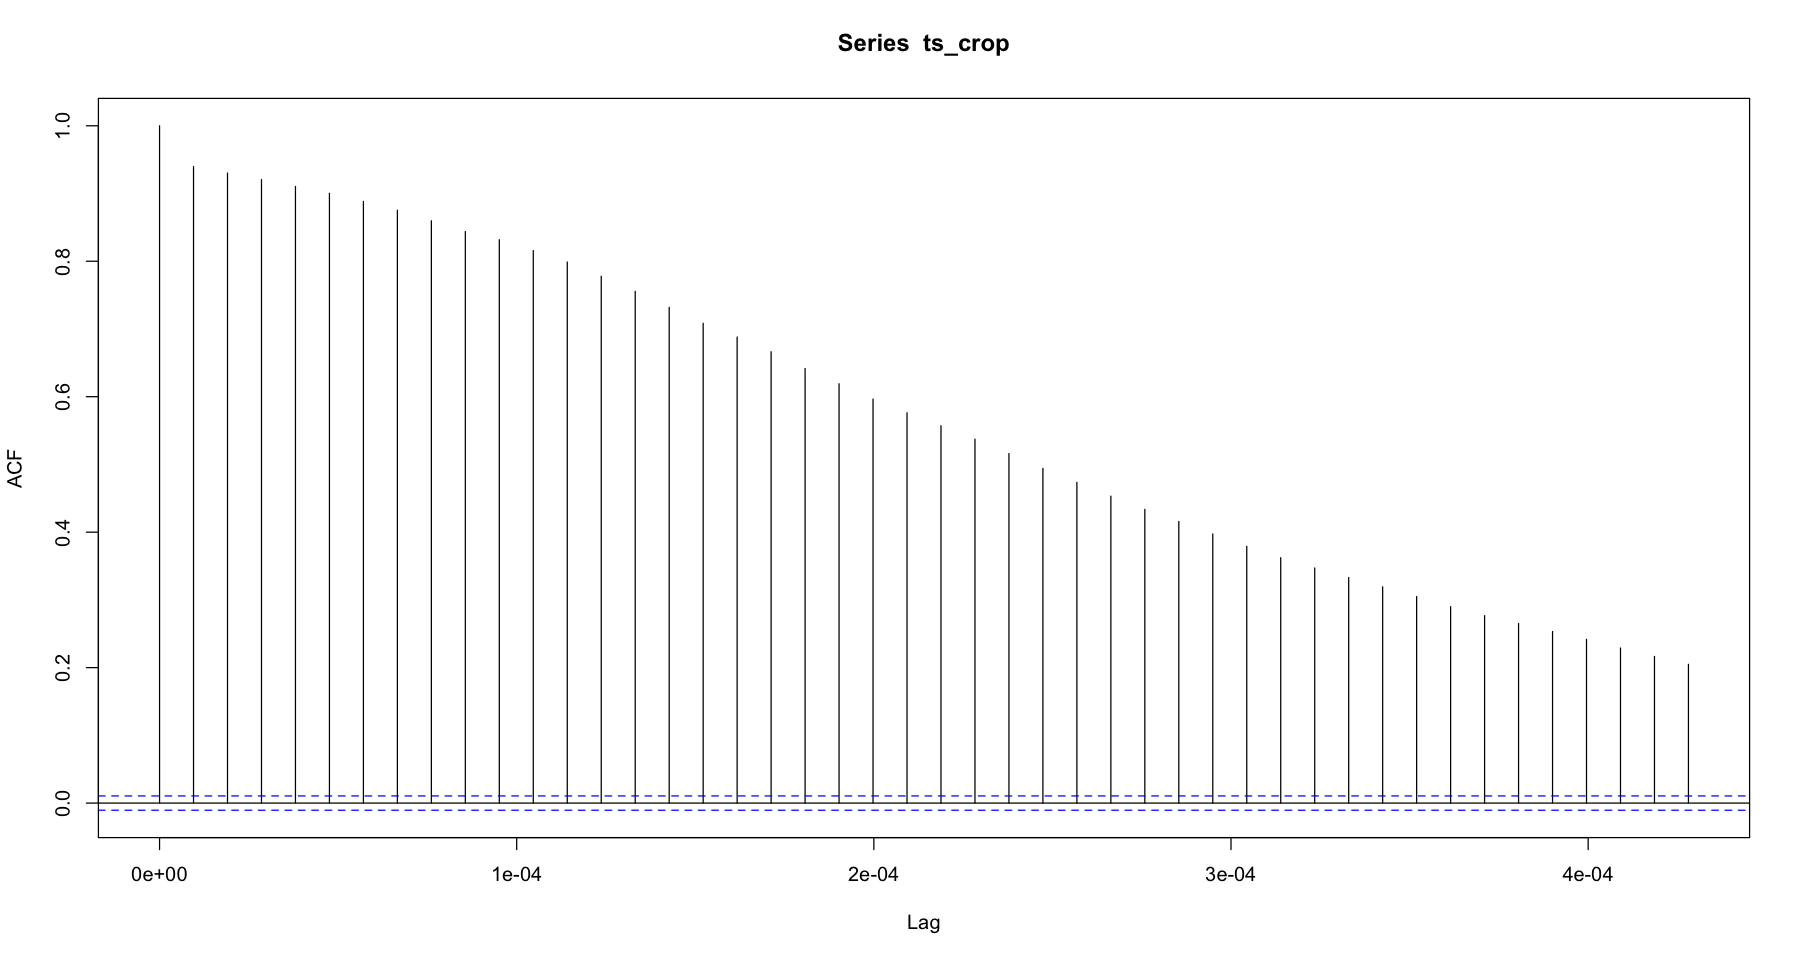

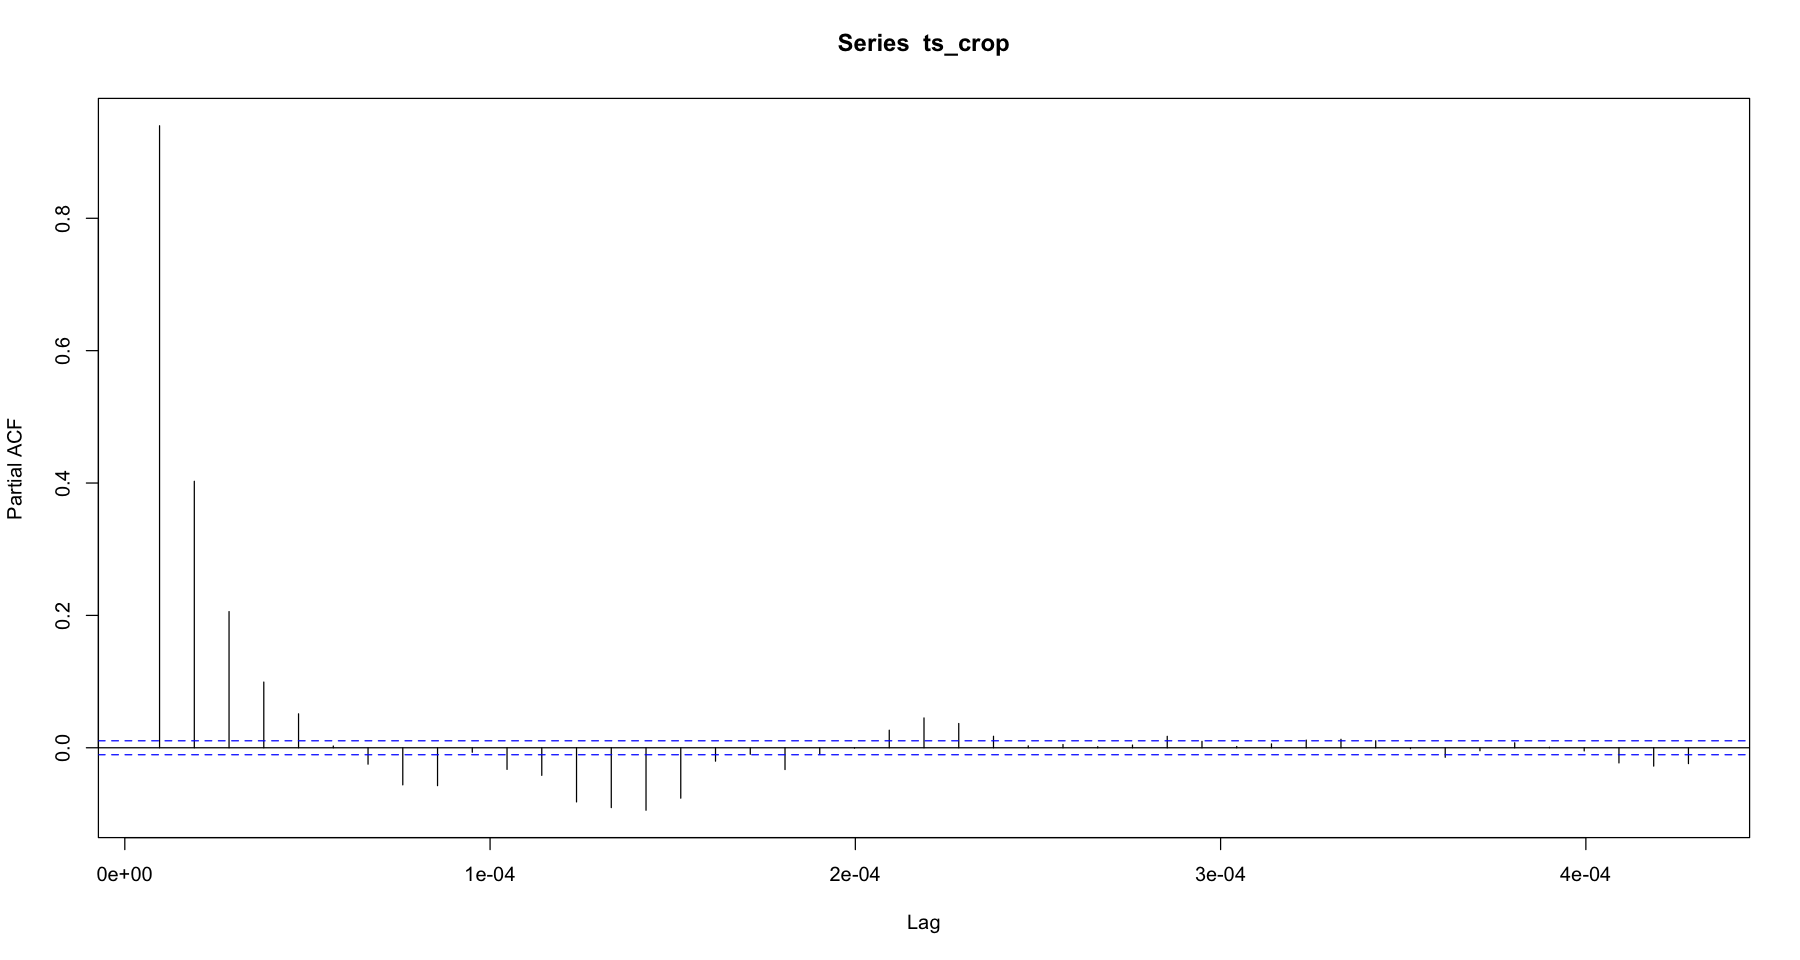

In [133]:
acf(ts_crop)
pacf(ts_crop)

Del ACF se puede observar que hay una correlación alta con valores pasados, pero el PACF nos dice cuánto para atrás debiamoers de ir para ajustar la serie.

### Periodicidad

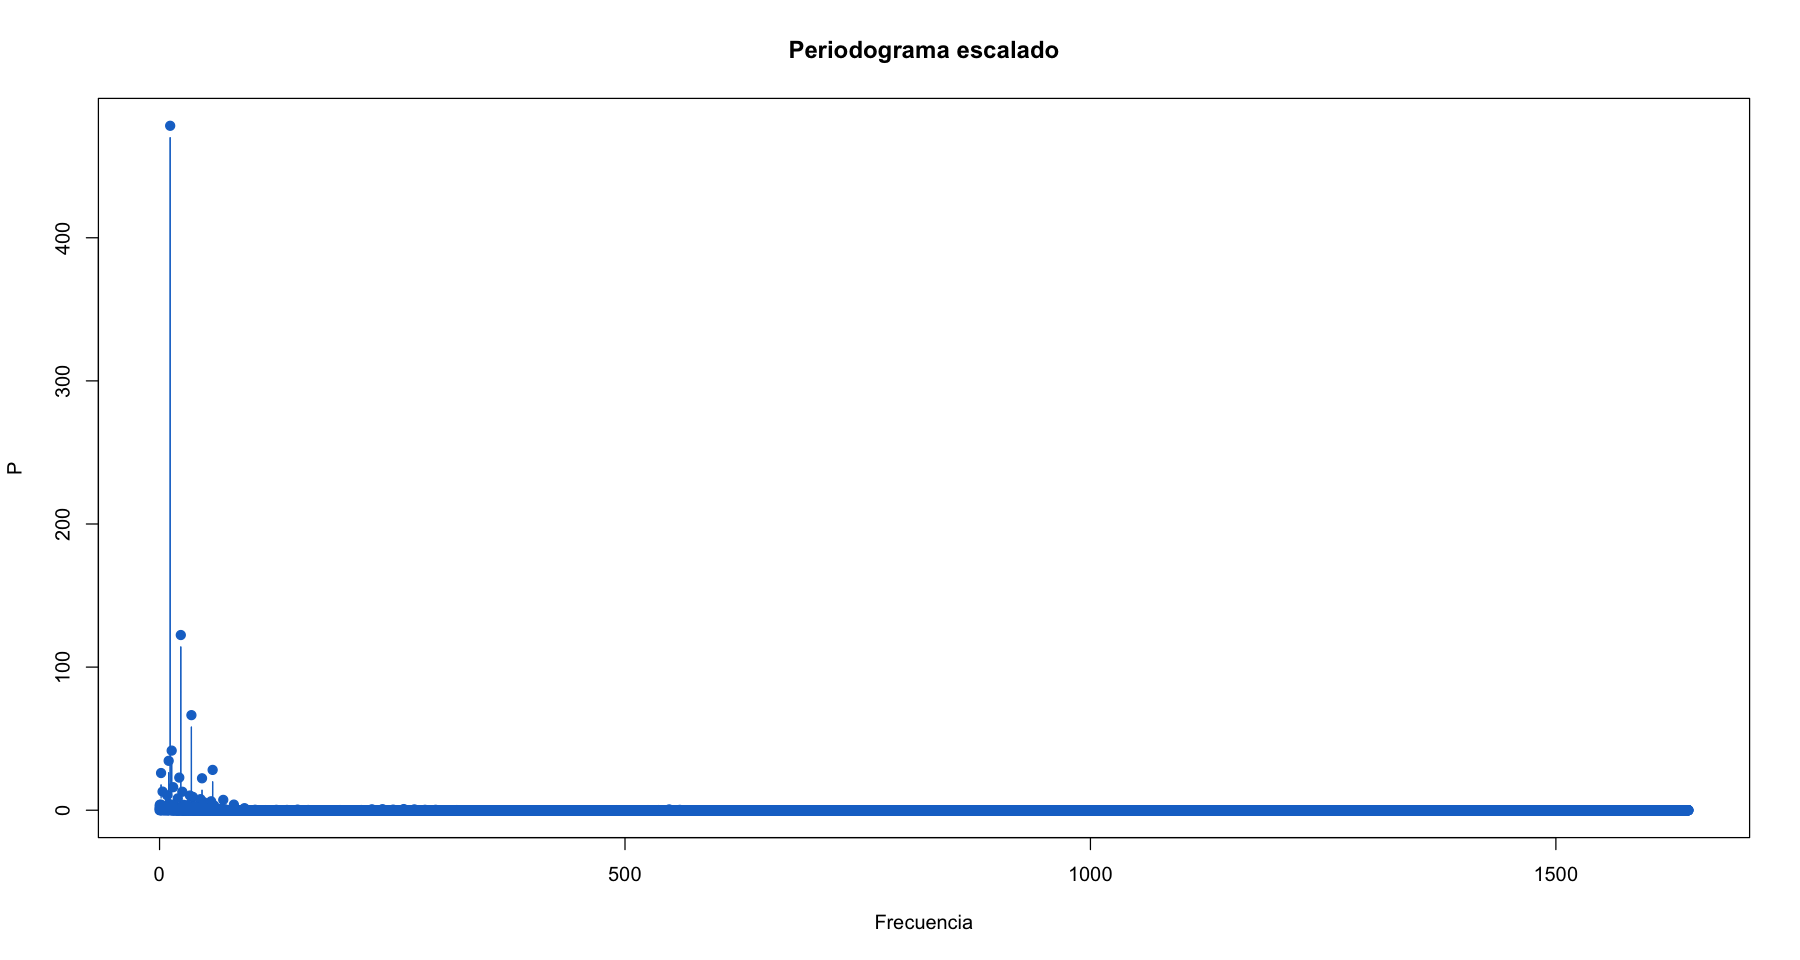

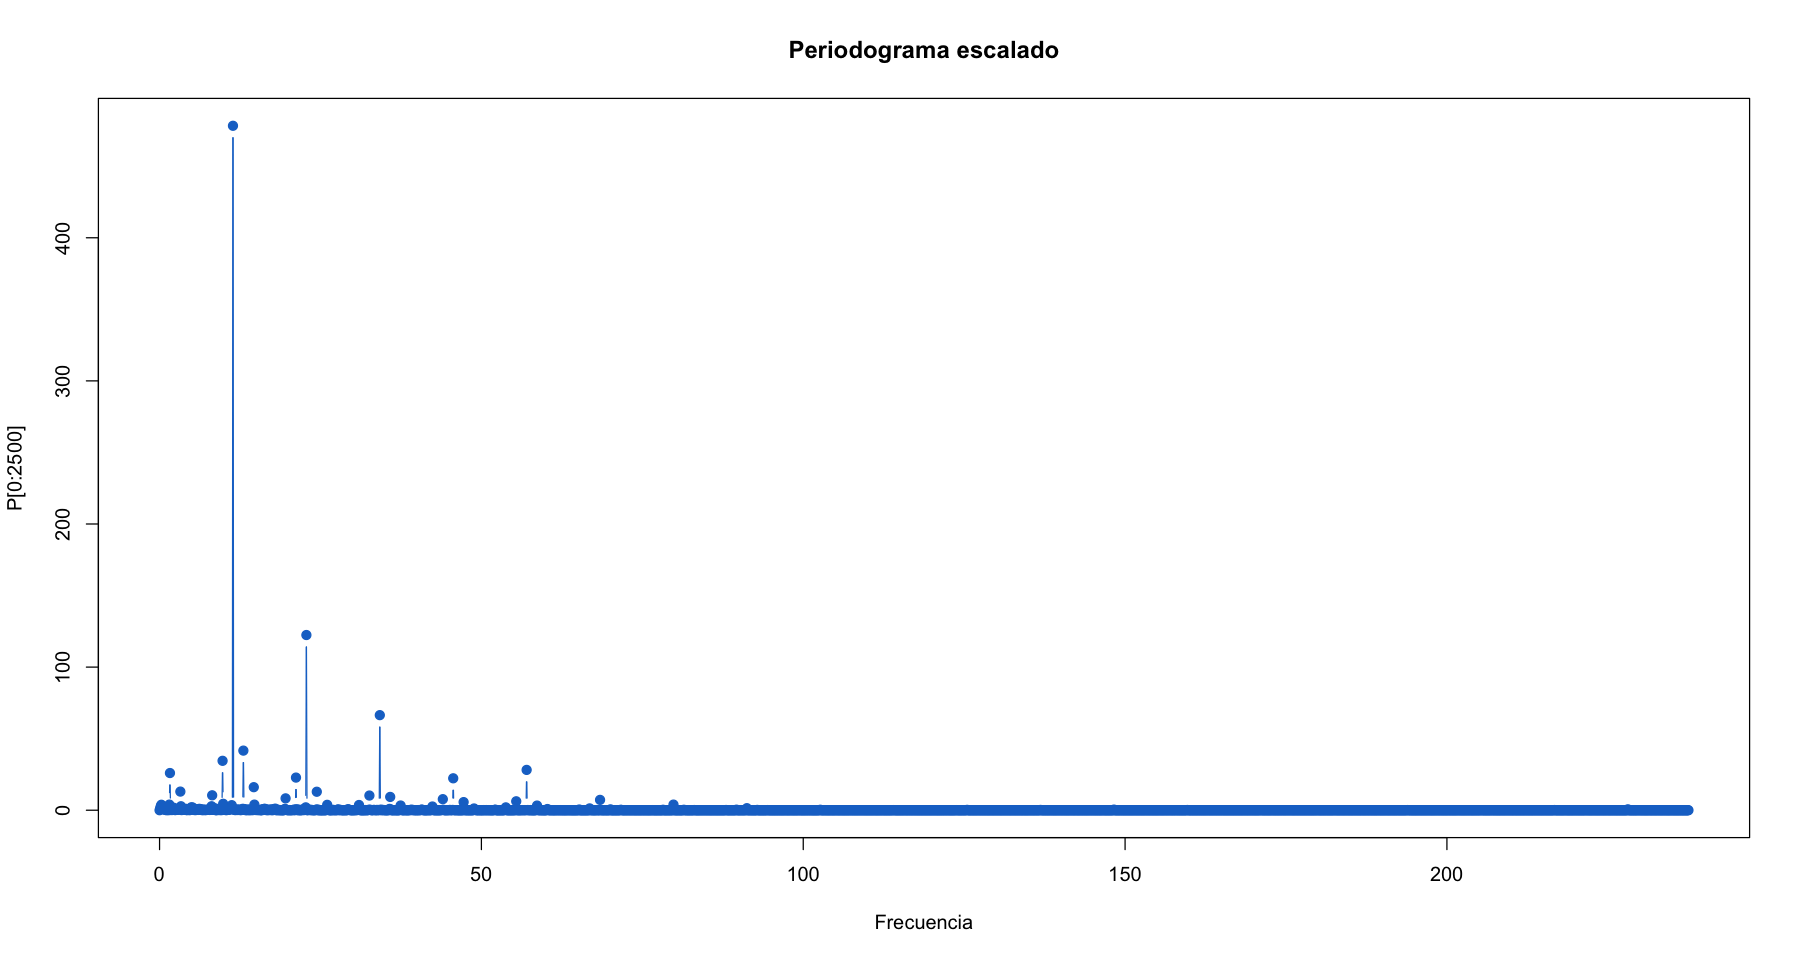

In [143]:
# Estudio de la periodicidad 

s = ts_crop
s = s-mean(s) # Se quita la media
n = length(s)
I = abs(fft(s))^2 #FFT y módulo cuadrado
I = I[1:floor(n/2)] #Recorto el vector a las frecuencias observables
P = (4/n^2)*I #Escalado del periodograma
f = (0:(n/2-1))/n*(freq_5min/96*3) #Vector de frecuencias para hacer el gráfico (se multiplica por la frecuencia de la serie, para normalizar

#Ploteo del periodograma
plot(f, P, type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)
plot(f[0:2500], P[0:2500], type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)

Del periodograma se pueden extraer las frecuencias principales. Buscamos los máximos del vector P para obtener el valor de las frecuencias.

In [ ]:
samples_per_day = 96
# Primera frecuencia de mayor importancia
f1 = f[which.max(P)]*samples_per_day/3
print(paste("f1:",f1))
print(paste("which.max(P1):",which.max(P)))

# Segunda frecuencia de mayor importancia
P[which.max(P)] = 0
f2 = f[which.max(P)]*samples_per_day/3
print(paste("f2:",f2))
print(paste("which.max(P2):",which.max(P)))

# Tercera frecuencia de mayor importancia
P[which.max(P)] = 0
f3 = f[which.max(P)]*samples_per_day/3
print(paste("f3:",f3))
print(paste("which.max(P3):",which.max(P)))

# Cuarta frecuencia de mayor importancia
P[which.max(P)] = 0
f4 = f[which.max(P)]*samples_per_day/3
print(paste("f4:",f4))
print(paste("which.max(P4):",which.max(P)))

# Quinta frecuencia de mayor importancia
P[which.max(P)] = 0
f5 = f[which.max(P)]*samples_per_day/3
print(paste("f5:",f5))
print(paste("which.max(P5):",which.max(P)))

In [ ]:
t = time(newdf_agg_ts)

# Creación de fit con las 2 frecuencias mas significativas halladas
fit_df_ts_crop = lm(newdf_agg_ts ~  cos(2*pi*f1*t)+sin(2*pi*f1*t)+cos(2*pi*f2*t)+sin(2*pi*f2*t))

summary(fit_df_ts_crop)

adjustment_fit_df_ts_crop = ts(fitted(fit_df_ts_crop), start=2017, freq=freq/3)
tsplot(newdf_agg_ts, col=4, lwd=2)
lines(adjustment_fit_df_ts_crop, lwd=2)

# Residuals del ajuste
residuals_fit = residuals(fit_df_ts_crop)

In [ ]:
# Ajuste para las primeras 2 semanas del dataframe
tsplot(head(newdf_agg_ts, samples_per_day*days_to_crop), col=4, lwd=2)
lines(head(adjustment_fit_df_ts_crop, samples_per_day*days_to_crop), lwd=2)

In [ ]:
# Ajuste para las últimas 2 semanas del dataframe
tsplot(tail(newdf_agg_ts, samples_per_day*days_to_crop), col=4, lwd=2)
lines(tail(adjustment_fit_df_ts_crop, samples_per_day*days_to_crop), lwd=2)

In [ ]:
acf(residuals_fit)

In [ ]:
pacf(residuals_fit)

In [ ]:
checkresiduals(residuals_fit)

Sigue habiendo una componente fuerte y 2 menores a pesar de haber ajustado la serie.

In [11]:
# Auto ARIMA con Seasonal
autoarima = auto.arima(newdf_agg_ts, seasonal = TRUE)
ajuste_autoarima = ts(fitted(autoarima), start=2017, freq=freq)
summary(autoarima)
residuals_autoarima = residuals(autoarima)

ERROR: Error in as.ts(x): object 'newdf_agg_ts' not found


In [12]:
acf(residuals_autoarima, na.action = na.pass)
pacf(residuals_autoarima, na.action = na.pass)

ERROR: Error in as.ts(x): object 'residuals_autoarima' not found


Con el Auto ARIMA se ve como el ACF y el PACF quedan limpios, sin encontrar correlación con valores pasados luego de aplicar un arima autoregresivo de orden 2, media móvil 3 e integrador 1.

Cortamos la serie a sus últimos meses ya que presenta más estabilidad en los datos.

In [13]:
cropped_agg_ts = tail(newdf_agg_ts,(96*7)*17)

tsplot(cropped_agg_ts)

s = cropped_agg_ts
s = s-mean(s) # Se quita la media
n = length(s)
I = abs(fft(s))^2 #FFT y módulo cuadrado
I = I[1:floor(n/2)] #Recorto el vector a las frecuencias observables
P = (4/n^2)*I #Escalado del periodograma
f = (0:(n/2-1))/n*(freq/3) #Vector de frecuencias para hacer el gráfico (se multiplica por la frecuencia de la serie, para normalizar

#Ploteo del periodograma
plot(f, P, type="b", xlab="Frecuencia", main="Periodograma escalado", col=4, lwd=1, pch=19)
plot(f[1:500], P[1:500], type="b", xlab="Frecuencia", main="Periodograma escalado acercado", col=4, lwd=1, pch=19)


ERROR: Error in tail(newdf_agg_ts, (96 * 7) * 17): object 'newdf_agg_ts' not found


In [14]:
samples_per_day = 96
# Primera frecuencia de mayor importancia
f1 = f[which.max(P)]#*samples_per_day/3
print(paste("f1:",f1))
print(paste("which.max(P1):",which.max(P)))

# Segunda frecuencia de mayor importancia
P[which.max(P)] = 0
f2 = f[which.max(P)]#*samples_per_day/3
print(paste("f2:",f2))
print(paste("which.max(P2):",which.max(P)))

# Tercera frecuencia de mayor importancia
P[which.max(P)] = 0
f3 = f[which.max(P)]#*samples_per_day/3
print(paste("f3:",f3))
print(paste("which.max(P3):",which.max(P)))

# Cuarta frecuencia de mayor importancia
P[which.max(P)] = 0
f4 = f[which.max(P)]#*samples_per_day/3
print(paste("f4:",f4))
print(paste("which.max(P4):",which.max(P)))

# Quinta frecuencia de mayor importancia
P[which.max(P)] = 0
f5 = f[which.max(P)]#*samples_per_day/3
print(paste("f5:",f5))
print(paste("which.max(P5):",which.max(P)))

ERROR: Error in eval(expr, envir, enclos): object 'f' not found


In [15]:
t = time(cropped_agg_ts)

# Creación de fit con las 2 frecuencias mas significativas halladas
fit_df_ts_cropped = lm(cropped_agg_ts ~ t + cos(2*pi*f1*t)+sin(2*pi*f1*t)+cos(2*pi*f2*t)+sin(2*pi*f2*t)++cos(2*pi*f3*t)+sin(2*pi*f3*t))

summary(fit_df_ts_cropped)

cropped_adjustment_fit_df_ts = ts(fitted(fit_df_ts_crop), start=t[1], freq=(freq*52/((3)*(365/7))))
tsplot(cropped_agg_ts, col=4, lwd=2)
lines(cropped_adjustment_fit_df_ts, lwd=2)

# Residuals del ajuste
cropped_residuals_fit = residuals(fit_df_ts_cropped)

ERROR: Error in time(cropped_agg_ts): object 'cropped_agg_ts' not found


In [16]:
tsplot(head(cropped_agg_ts, samples_per_day*days_to_crop*4), col=4, lwd=2)
lines(head(cropped_adjustment_fit_df_ts, samples_per_day*days_to_crop*4), lwd=2)

ERROR: Error in head(cropped_agg_ts, samples_per_day * days_to_crop * 4): object 'cropped_agg_ts' not found


In [17]:
checkresiduals(cropped_residuals_fit)

ERROR: Error in as.vector(set): object 'cropped_residuals_fit' not found


In [18]:
acf(cropped_residuals_fit)
pacf(cropped_residuals_fit)

ERROR: Error in as.ts(x): object 'cropped_residuals_fit' not found
